<a href="https://colab.research.google.com/github/Sourav-Manik/AI-Assignments/blob/main/Assignment_8_LSTM_(Consumer_compliants_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Import Libraries##

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
tf.keras.utils.pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SimpleRNN, SpatialDropout1D

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##2. Import Data##

In [ ]:
consumer_complaints_data = pd.read_csv('/content/drive/MyDrive/AI/consumer_complaints.csv')
consumer_complaints_data

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555952,07/01/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Bank of America,NaN,NaN,NaN,NaN,Referral,07/07/2014,Closed with explanation,Yes,No,919529
555953,07/01/2014,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Residential Credit Solutions,NaN,NaN,"Older American, Servicemember",NaN,Referral,07/23/2014,Closed with explanation,No,No,918447
555954,07/10/2012,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,BB&T Financial,NaN,NaN,NaN,NaN,Phone,11/18/2013,Closed with explanation,Yes,No,114550
555955,04/14/2015,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,NaN,NaN,Global Recovery Group,NaN,NaN,NaN,NaN,Phone,04/14/2015,Untimely response,No,No,1329963


##3. Data Understanding##

This data set is from US Government and our goal is to use sequence learners [RNN/LSTM] and try classifying it to one of the classes from column “Product”.  Given that this is a text classification problem and based on our internal analysis, we have realized that this task can be well achieved using column “Consumer Complaint Narrative”, but if required participants are free to explore other columns.

Assumption - 

As advised by client we'll use only “Consumer Complaint Narrative” as input feature and "Product" as our output feature.

Also "date" doesn't seem material for this classification. Thus will also drop this feature.

In [ ]:
consumer_complaints_data.dtypes

date_received                   object
product                         object
sub_product                     object
issue                           object
sub_issue                       object
consumer_complaint_narrative    object
company_public_response         object
company                         object
state                           object
zipcode                         object
tags                            object
consumer_consent_provided       object
submitted_via                   object
date_sent_to_company            object
company_response_to_consumer    object
timely_response                 object
consumer_disputed?              object
complaint_id                     int64
dtype: object

In [ ]:
labels = consumer_complaints_data['product'].unique()
labels

array(['Mortgage', 'Credit reporting', 'Student loan', 'Debt collection',
       'Credit card', 'Bank account or service', 'Consumer Loan',
       'Money transfers', 'Payday loan', 'Prepaid card',
       'Other financial service'], dtype=object)

In [ ]:
consumer_complaints_data['product'].value_counts()

Mortgage                   186475
Debt collection            101052
Credit reporting            91854
Credit card                 66468
Bank account or service     62563
Consumer Loan               20990
Student loan                15839
Payday loan                  3877
Money transfers              3812
Prepaid card                 2470
Other financial service       557
Name: product, dtype: int64

##4. Data Preparation##

In [ ]:
consumer_complaints_data = consumer_complaints_data[['product','consumer_complaint_narrative']]
consumer_complaints_data

,product,consumer_complaint_narrative
0,Mortgage,NaN
1,Mortgage,NaN
2,Credit reporting,NaN
3,Student loan,NaN
4,Debt collection,NaN
...,...,...
555952,Mortgage,NaN
555953,Mortgage,NaN
555954,Mortgage,NaN
555955,Debt collection,NaN


In [ ]:
consumer_complaints_data.dtypes

product                         object
consumer_complaint_narrative    object
dtype: object

In [ ]:
consumer_complaints_data.shape

(555957, 2)

With client approval we'll be dropping Nan Values from 
"consumer_complaint_narrative"

In [ ]:
consumer_complaints_data = consumer_complaints_data.dropna(axis = 0)
consumer_complaints_data.reset_index(drop = True, inplace=True)

consumer_complaints_data

,product,consumer_complaint_narrative
0,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
1,Consumer Loan,Due to inconsistencies in the amount owed that...
2,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
3,Mortgage,I have an open and current mortgage with Chase...
4,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...
...,...,...
66801,Credit reporting,"XXXX XXXX is reporting incorrectly, payments h..."
66802,Credit reporting,Reflecting incorrect payment status. Have been...
66803,Payday loan,I have been paying {$180.00} a month through d...
66804,Mortgage,I recently became aware that Amerisave Mortgag...


In [ ]:
consumer_complaints_data.shape

(66806, 2)

In [ ]:
consumer_complaints_data['product'].value_counts()

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Money transfers              666
Other financial service      110
Name: product, dtype: int64

##Text Preprocessing

**Text preprocessing will include the following steps:**


Convert all text to lower case.

Replace REPLACE_BY_SPACE_RE symbols by space in text.

Remove symbols that are in BAD_SYMBOLS_RE from text.

Remove “x” in text.

Remove stop words.

Remove digits in text.

In [ ]:
def print_plot(index):
    example = consumer_complaints_data[consumer_complaints_data.index == index][['product','consumer_complaint_narrative']].values[0]

    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])
print_plot(10)

Mortgage
Product: I am very disappointed that the CFPB did not help to resolve this fraudulant loan. # XXXX between XXXX XXXX and XXXX, FF ( AKA ) One West. Case # XXXX with CFPB. 



In [ ]:
consumer_complaints_data = consumer_complaints_data.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
consumer_complaints_data['consumer_complaint_narrative'] = consumer_complaints_data['consumer_complaint_narrative'].apply(clean_text)
consumer_complaints_data['consumer_complaint_narrative'] = consumer_complaints_data['consumer_complaint_narrative'].str.replace('\d+', '')

In [ ]:
print_plot(100)

Consumer Loan
Product: contacted drivetime several different occasions regarding car loan account # number loan removed also credit bureau positive credit rating closed paid full company insisted avoiding agreement entered company representative corporate position agreed upon resolution provide agency copy capability computer drivetime month removed credit reporting information credit bureaus reporting agencies believe discovered positive credit ratings longer credit bureaus another positive account another car loan longer reporting credit file removals adversely affected credit ratings ability purchase something lower interest rate never missed payment drivetime company car loans inclusive different auto loans destroy credit ratings despicable spoke today regarding issues response drivetime process updating consumers credit files consumers credit files removed credit bureaus updated however know process performed records updated corrected process timeframes process take furthermore pr

#LSTM Modeling


Vectorize consumer complaints text, by turning each text into either a sequence of integers or into a vector.

Limit the data set to the top 50,000 words.

Set the max number of words in each complaint at 250.

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(consumer_complaints_data['consumer_complaint_narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 56802 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(consumer_complaints_data['consumer_complaint_narrative'].values)
X = tf.keras.utils.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (66806, 250)


In [ ]:
X

array([[   0,    0,    0, ..., 1166,   40,  193],
       [   0,    0,    0, ..., 2044,  168,  191],
       [1125,  385, 4134, ...,  557, 3398, 1845],
       ...,
       [   0,    0,    0, ...,   48, 1105,   84],
       [   0,    0,    0, ...,   67,  936,  312],
       [2699, 1842, 1061, ..., 1540,    2,  721]], dtype=int32)

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder() #applying label encoder to my dependent feature
Y = labelencoder.fit_transform(consumer_complaints_data['product'])

In [ ]:
Y

array([4, 1, 6, ..., 8, 6, 6])

In [ ]:
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (66806,)


In [ ]:
# Y = pd.get_dummies(consumer_complaints_data['product']).values
# print('Shape of label tensor:', Y.shape)
# Y

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(60125, 250) (60125,)
(6681, 250) (6681,)


In [ ]:
consumer_complaints_data['product'].value_counts()

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Money transfers              666
Other financial service      110
Name: product, dtype: int64

In [ ]:
classes = np.unique(Y_train)
classes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
from sklearn.utils import compute_class_weight           #Handling Imbalance Data


class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(Y_train),
                                     y = Y_train)
class_weights = dict(zip(np.unique(Y_train), class_weights))
class_weights

{0: 1.0661028068868912,
 1: 1.652330438606134,
 2: 0.7676838610827375,
 3: 0.48426588915647123,
 4: 0.34576854066985646,
 5: 9.248577141978156,
 6: 0.4059948815946736,
 7: 55.211202938475665,
 8: 8.540482954545455,
 9: 7.117069128787879,
 10: 2.8557518761280516}

In [ ]:
from sklearn.utils import class_weight
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(11, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

In [ ]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,class_weight = class_weights)

Epoch 1/5
846/846 [==============================] - 707s 833ms/step - loss: 1.8173 - accuracy: 0.5091 - val_loss: 1.2292 - val_accuracy: 0.6203
Epoch 2/5
846/846 [==============================] - 684s 809ms/step - loss: 1.3730 - accuracy: 0.6330 - val_loss: 1.1963 - val_accuracy: 0.6554
Epoch 3/5
846/846 [==============================] - 685s 810ms/step - loss: 1.0756 - accuracy: 0.7237 - val_loss: 0.9349 - val_accuracy: 0.7303
Epoch 4/5
846/846 [==============================] - 682s 806ms/step - loss: 0.8615 - accuracy: 0.7742 - val_loss: 0.9945 - val_accuracy: 0.7196
Epoch 5/5
846/846 [==============================] - 678s 801ms/step - loss: 0.6851 - accuracy: 0.7891 - val_loss: 0.8197 - val_accuracy: 0.7500


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

209/209 [==============================] - 17s 80ms/step - loss: 0.8331 - accuracy: 0.7499
Test set
  Loss: 0.833
  Accuracy: 0.750


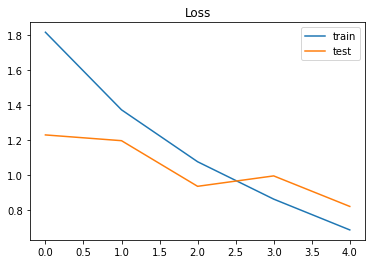

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

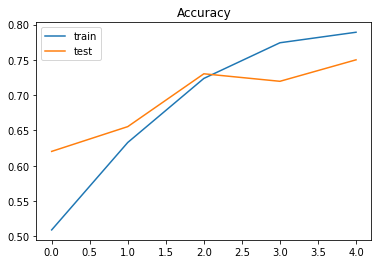

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

Test with a New Complaint


In [ ]:
new_complaint = ['I am a victim of credit card fraud and I believe someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : 557896581259.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = tf.keras.utils.pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
#labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 429ms/step
[[0.27576202 0.00236376 0.66538936 0.00265244 0.00367621 0.00760424
  0.0010833  0.03668286 0.00121393 0.00216478 0.00140709]] Student loan


End